The goal with this exercise is to implement Batch Gradient Descent with early stopping for Softmax Regression (without using Scikit-Learn)
As it is softmax regression this entails that the classes that we are classifying be exclusive


We are going to work on the MNIST Data set as the classes are exclusive and it's easy to load

As a baseline I will implement it with scikit learn and then look through the chapter on 
how to implement it without


Later features I want to add is plotting val error and training error while gradient descent is training

## Given

The chapter in the Aurelion Geron O'Reilly book gave a basic function for early stopping (perhaps we can make some embellishments):

In [ ]:
#from sklearn.base import clone
#
##prepare the data
#poly_scaler = Pipeline([
#    ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
#    ("std_scaler", StandardScaler())
#])
#X_train_poly_scaled = poly_scaler.fit_transform(X_train)
#X_val_poly_scaled = poly_scaler.transform(X_val)
#
#sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
#                       penalty=None, learning_rate="constant", eta0=0.0005)
#
#minimum_val_error = float("inf")
#best_epoch = None
#best_model = None
#for epoch in range(1000):
#    sgd_reg.fit(X_train_poly_scaled, y_train)   #continues where it left off
#    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
#    val_error = mean_squared_error(y_val, y_val_predict)
#    if val_error < minimum_val_error:
#        minimum_val_error = val_error
#        best_epoch = epoch
#        best_model = clone(sgd_reg)

Also we are given the equations for the softmax score for class k, softmax function, softmax regression classifier prediction, cross entropy cost function, and cross entropy gradient vector for class k.

Softmax Score:
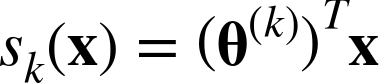
Softmax Function:
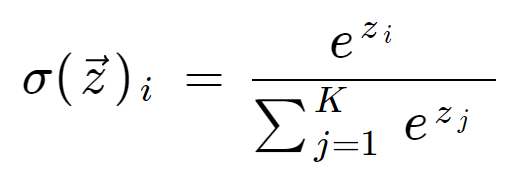
Softmax Regression Classifier Prediction:
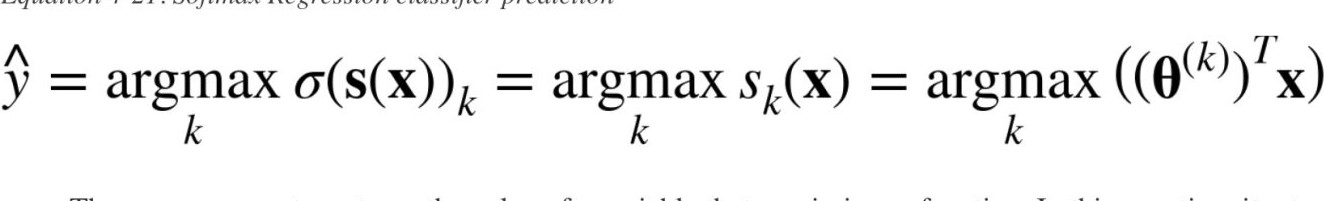
Cross Entropy Cost Function:
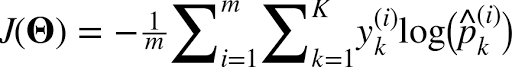
Cross Entropy Gradient Vector for Class k:
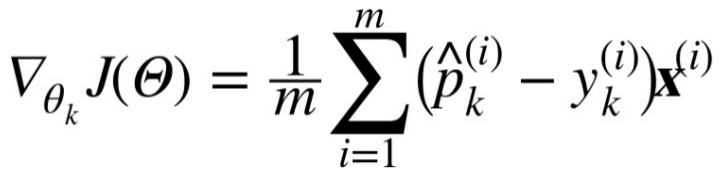

# **Initial Thoughts on How I Want to Approach This**

The softmax score is used for scoring probabilities, softmax function is used for estimating the probability that an instance belongs to a given class, and the cross entropy cost is used to penalize incorrect classifications. I think for batch gradient descent the entire batch is predicted and then the gradient is calculated based on the cost of all of the predictions.
Thus, each instance will 1.) get scored for each class (k) with randomly initialized weights in the parameter matrix using a transform dot product between the values for x instance and the weights of each class's parameter vector. 2.) calculate the sigmoid (compute the exponential of each score, add them all together, and then save each exponential and divide by the sum of these exponentials) of each class's score to find the probability that each instance belongs to a given class 3.) using the scores for each class from the softmax function as p-hat, find the gradient vector (partial derivative) of the function with respect to each weight for each class's parameter vector. 4) Iterate over each instance in the batch saving each gradient vector per class. 5.) As we're using gradient descent as our optimization function, multiply the sum of each partial derivative for each given class by the learning rate and subtract it's value from each weight it corresponds to. 6.) Stop optimizing when a desirable lowest cost possible has been reached.

Simple! lol


Now somethings that will be needed are parameter matrices (probably using numpy arrays). One will be needed per class
For dot product to work each parameter matrix must have the same number of values as the feature vector for each instance.
For clean code it may be nice to write a single p-hat variable (for storing the softmax score) to represent any class present and then iterate over the number of classes 



# Baseline

In [ ]:
#import digit classifier
import numpy as np
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
X, y = mnist['data'], mnist['target']
X.shape

In [ ]:
X[0].reshape(28,28)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state = 42)
print("X_train size:", X_train.shape, '\n',
    "X_val size:", X_val.shape, '\n',
    "y_train size:", y_train.shape, '\n',
    "y_val size:", y_val.shape, '\n')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X_train, y_train)
val_predictions = softmax_reg.predict(X_val)
val_score = accuracy_score(y_val, val_predictions)
val_score

So without any tuning of parameters our sklearn softmax regressor with batch gradient descent scores a 91.81% accuracy. This will be our baseline when we're writing our classifier from scratch. Hopefully we can score somewhere in this neighborhood.

# Initial Build Out with Functions and Testing

In [ ]:
x_of_i = np.array([0.49935697, 0.66791422, 0.09503283]) #came about this number by np.random.rand(3)
theta = np.array([0.91951609, 0.50811574, 0.02401766]) #ditto
print('x =', x_of_i, '\n',
     'weight vector = ', theta, '\n',
     'their dot product = ', x_of_i.T.dot(theta))

In [ ]:
x_2_of_i = np.random.rand(3)
theta_of_x_2 = np.array([0.38088662, 0.17961605, 0.23630125]) #np.random.rand(3)
instance_matrix = np.array([x_of_i, x_2_of_i])
parameter_matrix = np.array([theta, theta_of_x_2])
#hopefully the dot product will be the same for the first instance
print('instance matrix =', instance_matrix, '\n',
     'parameter matrix =', parameter_matrix, '\n',
     'result =', instance_matrix.T.dot(parameter_matrix))

In [ ]:
#it didn't work, so I'm going to try to split up the rows into separate vectors again
for x, w in zip(instance_matrix, parameter_matrix):
    print('x =', x, '\n',
         'w =', w)
    print(x.T.dot(w))
print(instance_matrix[0])
print(x_of_i)
print(parameter_matrix[0])
print(theta)
print(x_of_i.T.dot(theta))
#and NOWWWW it works
    

In [ ]:
for vector in parameter_matrix:
    print(instance_matrix[0].T.dot(vector))
    

First Build Out of Functions

In [ ]:
def SoftmaxScore(x, theta):
    scores = []
    standardized_scores = []
    for vector in theta:
        scores.append(x.T.dot(vector)) 
    for score in scores:
        standardized_scores.append(score/sum(scores)) #standardizing scores so that they don't get too large to compute probabilities for
    return np.array(standardized_scores)

def SoftmaxFunction(scores):
    p_hat = []
    for score in scores:
        p_hat.append(np.exp(score)/np.sum(np.exp(scores)))
    return np.array(p_hat)

def CalculatePartialDerivative(probability, y, x, batch_size):
    return ((probability - y)*x)/batch_size
    
def GetInstanceGradientVector(p_hat, y, x, batch_size):
    vector = []
    total_cost = []
    for probability in p_hat:
        if y == np.where(p_hat == probability)[0][0]: #this evaluates if each possible class is the ground truth or not
            y_of_class = 1 

        else:
            y_of_class = 0

        instance_gradient_vector = CalculatePartialDerivative(probability, y_of_class, x, batch_size)
        vector.append(instance_gradient_vector)
        cost =  CrossEntropyCost(probability, y_of_class, batch_size)
        total_cost.append(cost)
    cost = np.sum(total_cost)
    return np.array(vector), cost

def CrossEntropyCost(probability, y, batch_size):
    cost = -1 * y * np.log(probability)/batch_size
    return cost
        
def MakeGradientStep(gradient, learning_rate, W):
    W = W - (gradient * learning_rate)
    return W

def predict(X, y, theta):
    predictions = []
    for x in X:
        p_hat = SoftmaxFunction(SoftmaxScore(x, theta))
        prediction = np.max(p_hat)
        predictions.append(np.unique(y)[np.where(p_hat == prediction)[0][0]]) #translates the index back to the class
    return np.array(predictions)
        
def fit(X, y, batch_size, theta, classes, learning_rate):
    num_features = X.shape[1]
    current_best_cost = float('inf')
    counter_since_the_last_best = 5

    max_iter = 20
    for epoch in range(max_iter):
        costs = []
        gradients = []
        print('This is epoch:', epoch)
        for x_i, y_i in zip(X, y):
            y_i = np.where(classes == y_i)[0][0] #turns the value of the class into the index of the class that it represents
            scores = SoftmaxScore(x_i, theta) #this will return a parameter matrix for a single instance
            p_hat = SoftmaxFunction(scores) 
            gradient_vector_of_i, cost_of_i = GetInstanceGradientVector(p_hat, y_i, x_i, batch_size)
            gradients.append(gradient_vector_of_i)
            costs.append(cost_of_i)
        batch_costs = np.array(costs)
        total_cost = np.sum(batch_costs, axis = 0)
        batch_vectors = np.array(gradients) #should be in the right shape to be summed at axis 0
        batch_gradient = np.sum(batch_vectors, axis = 0)
        print('Cost is:', total_cost)
        print("Validation accuracy is:", accuracy_score(y_val, predict(X_val, y, theta)))
        if total_cost < current_best_cost:    #trying to discern if cost starts to go up
            current_best_cost = total_cost
            best_epoch = epoch
            best_theta = theta
            theta = MakeGradientStep(batch_gradient, learning_rate, theta)
        else:
            counter_since_the_last_best -= 1   #when we've gone 5 steps past our best model we will stop iterating
            theta = MakeGradientStep(batch_gradient, learning_rate, theta)
        if counter_since_the_last_best == 0:
            break
        else:
            continue
    return theta

    
def My_Softmax_Regressor(X, y, learning_rate=1):
    num_classes = len(np.unique(y))
    classes = np.unique(y)
    batch_size = X.shape[0]
    num_features = X.shape[1]
    theta = np.random.rand(num_classes, num_features) #creates a parameter matrix with random values
    print(theta)
    theta = fit(X, y, batch_size, theta, classes, learning_rate)
    return theta


# Testing of each function

Softmax score function test

In [ ]:
scores = SoftmaxScore(x_of_i, parameter_matrix)
print(scores)
#to compare with the dot product of the instance of x and each parameter vector
for vector in parameter_matrix:
    print(x_of_i.T.dot(vector))

Looks like this function works well

Softmax function test

In [ ]:
#I will put in the softmax scores as arguments
probabilities = SoftmaxFunction(SoftmaxScore(x_of_i, parameter_matrix))
print(probabilities)

Given that the first value's score was higher it makes sense that the calculated probability would be higher

Gradient vector for each instance function test

In [ ]:
fake_y = [1, 4, 5, 2, 3, 0] #the first index will get used, which will say that the lower probability option was correct
print(fake_y[0])
instance_vector, cost = GetInstanceGradientVector(probabilities, fake_y[0], x_of_i, batch_size = 1)
print(instance_vector)
print(probabilities)
print(x_of_i * (probabilities[1]-1))
print(((probabilities[0] - 0) * x_of_i)/1 )
print(((probabilities[1] - 1) * x_of_i)/1 )
print(np.where(probabilities == probabilities[0])[0][0])
print(cost)
costs = [cost, cost]
costs = np.array(costs)
print(np.sum(costs, axis = 0)) #looks good to me

This looks like it worked right, because the gradient is greater for the first index, thus it is penalizing the incorrect guess.

Gradient step function test

In [ ]:
#supply the instance vector from the last cell as arguments
learning_rate = .1 #arbitrary learning rate for testing
print('Here is the parameter matrix before stepping down the gradient', parameter_matrix)
parameter_matrix = MakeGradientStep(instance_vector, learning_rate, parameter_matrix)
print('Here is the parameter matrix after stepping down the gradient', parameter_matrix)

This looks right as the incorrect answer in the first index had its weights reduced

Prediction function test

In [ ]:
#it should choose class 0 still as the weights are higher there
print(x_of_i)
y_to_show_classes = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
predict(np.array([x_of_i]), y_to_show_classes, parameter_matrix) 

It accurately predicted based on the higher weight
Let's repeat this gradient step process some times to see if the prediction gets any better

In [ ]:
for x in range(10):
    scores = SoftmaxScore(x_of_i, parameter_matrix)
    probabilities = SoftmaxFunction(scores)
    instance_vector, cost = GetInstanceGradientVector(probabilities, fake_y[0], x_of_i, batch_size = 1)
    print(cost)
    parameter_matrix = MakeGradientStep(instance_vector, learning_rate, parameter_matrix)
    print(predict(np.array([x_of_i]), y_to_show_classes, parameter_matrix))

Perfect!
After 5 gradient descent steps, the regressor predicted more accurately. Also cost is reduced at each gradient step as desired!

In [ ]:

learning_rate = 1
theta = My_Softmax_Regressor(X_train[0:1000], y_train[0:1000], learning_rate)

It works!

# Rewriting Functions into a Class

In [ ]:
class My_Softmax_Regressor():
    def __init__(self, max_iter=10, learning_rate=1, warm_start=False):
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.warm_start = warm_start
        self.theta = []
        
    def SoftmaxScore(self, x):
        scores = []
        standardized_scores = []
        for vector in self.theta:
            scores.append(x.T.dot(vector)) 
        for score in scores:
            standardized_scores.append(score/sum(scores)) #standardizing scores so that they don't get too large to compute probabilities for
        return np.array(standardized_scores)
    
    def SoftmaxFunction(scores):
        p_hat = []
        for score in scores:
            p_hat.append(np.exp(score)/np.sum(np.exp(scores)))
        return np.array(p_hat)
    
    def CalculatePartialDerivative(self, probability, y, x):
        return ((probability - y)*x)/self.batch_size
    
    def CrossEntropyCost(self, probability, y):
        cost = -1 * y * np.log(probability)/self.batch_size
        return cost
        
    def GetInstanceGradientVector(self, p_hat, y, x):
        vector = []
        total_cost = []
        for probability in p_hat:
            if y == np.where(p_hat == probability)[0][0]:   #this evaluates if each possible class is or is not the ground truth 
                y_of_class = 1 
    
            else:
                y_of_class = 0

            instance_gradient_vector = My_Softmax_Regressor.CalculatePartialDerivative(self, probability, y_of_class, x)
            vector.append(instance_gradient_vector)
            cost = My_Softmax_Regressor.CrossEntropyCost(self, probability, y_of_class)
            total_cost.append(cost)
        cost = np.sum(total_cost)
            
        return np.array(vector), cost
            
    def MakeGradientStep(self, gradient):
        self.theta = self.theta - (gradient * self.learning_rate)
        return self.theta
            
    def fit(self, X, y):
        self.num_classes = len(np.unique(y))
        self.classes = np.unique(y)
        self.batch_size = X.shape[0]
        self.num_features = X.shape[1]
        #print(self.warm_start)
        #print(self.theta)
        if self.warm_start == True and self.theta == []:
            self.theta = np.random.rand(self.num_classes, self.num_features)
        if self.warm_start == False:
            self.theta = np.random.rand(self.num_classes, self.num_features)
        current_best_cost = float('inf')
        counter_since_the_last_best = 0
        for epoch in range(self.max_iter):
            costs = []
            gradients = []
            print('This is epoch:', epoch)
        
    
            for x_i, y_i in zip(X, y):
                y_i = np.where(self.classes == y_i)[0][0] #turns the value of the class into the index of the class that it represents
                scores = My_Softmax_Regressor.SoftmaxScore(self, x_i) #this will return a parameter matrix for a single instance
                p_hat = My_Softmax_Regressor.SoftmaxFunction(scores) 
                gradient_vector_of_i, cost_of_i = My_Softmax_Regressor.GetInstanceGradientVector(self, p_hat, y_i, x_i)
                gradients.append(gradient_vector_of_i)
                costs.append(cost_of_i)
            batch_costs = np.array(costs)
            total_cost = np.sum(batch_costs, axis = 0)
            batch_vectors = np.array(gradients) #should be in the right shape to be summed at axis 0
            batch_gradient = np.sum(batch_vectors, axis = 0)
            print('Cost is:', total_cost)
            print("Validation accuracy is:", accuracy_score(y_val, My_Softmax_Regressor.predict(self, X_val)))
            if total_cost < current_best_cost:    #trying to discern if cost starts to go up
                current_best_cost = total_cost
                best_epoch = epoch
                best_theta = self.theta
                theta = My_Softmax_Regressor.MakeGradientStep(self, batch_gradient)
            else:
                counter_since_the_last_best += 1   #when we've gone 5 steps past our best model we will stop iterating
                self.theta = My_Softmax_Regressor.MakeGradientStep(batch_gradient)
            if counter_since_the_last_best == 5:
                break
            else:
                continue
        return self
        #return self.theta
    
    def predict(self, X):
        predictions = []
        for x in X:
            p_hat = My_Softmax_Regressor.SoftmaxFunction(My_Softmax_Regressor.SoftmaxScore(self, x))
            prediction = np.max(p_hat)
            predictions.append(self.classes[np.where(p_hat == prediction)[0][0]]) #translates the index back to the class
            #predictions.append(np.unique(y)[np.where(p_hat == prediction)[0][0]]) #translates the index back to the class
        return np.array(predictions)
    
    

In [ ]:
learning_rate = 0.5
s_max = My_Softmax_Regressor(learning_rate=learning_rate)
s_max.fit(X_train[0:2000], y_train[0:2000])
preds = s_max.predict(X_val)
print(preds)
score = accuracy_score(y_val, preds)
score

In [ ]:
s_max = My_Softmax_Regressor(max_iter=1, warm_start = True) #warm_start so that the theta (parameter matrix) is not randomly initialized again
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(50):
    s_max.fit(X_train[0:5000], y_train[0:5000])   #continues where it left off
    y_val_predict = s_max.predict(X_val)
    val_error = accuracy_score(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = s_max

In [ ]:
preds = s_max.predict(X_val)
print(preds)
score = accuracy_score(y_val, preds)
score

It looks like it works! As the accuracy on the validation set is greater than the final validation accuracy printed from the function, it looks like the best model was saved.